# Machine Learning Models for a Network Intrusion Detector

## BY Sirish Prabakar 


# Main feature 1: Fully connected neural network 

In [1]:
%matplotlib inline
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
import pandas as pd



# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y):
    fpr, tpr, thresholds = roc_curve(y, pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()



# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

def to_xy2(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
    
    
    
    
    
    


from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers


preprocess = True



filename_read = os.path.join(r"C:\Users\siris\OneDrive\Desktop\datasets\PROJECT1\combined_csv.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])
df.dropna()
df.drop('id', axis=1)
# create feature vector
encode_text_dummy(df, 'proto')
encode_text_dummy(df, 'service')
encode_text_dummy(df, 'state')
encode_text_dummy(df, 'attack_cat')
encode_text_index(df, 'label')
 

if preprocess:
    encode_numeric_zscore(df, 'dur')
    encode_numeric_zscore(df, 'spkts')
    encode_numeric_zscore(df, 'dpkts')
    encode_numeric_zscore(df, 'sbytes')
    encode_numeric_zscore(df, 'dbytes')
    encode_numeric_zscore(df, 'rate')
    encode_numeric_zscore(df, 'sttl')
    encode_numeric_zscore(df, 'dttl')
    encode_numeric_zscore(df, 'sload')
    encode_numeric_zscore(df, 'dload')
    encode_numeric_zscore(df, 'sloss')
    encode_numeric_zscore(df, 'dloss')
    encode_numeric_zscore(df, 'sinpkt')
    encode_numeric_zscore(df, 'dinpkt')
    encode_numeric_zscore(df, 'sjit')
    encode_numeric_zscore(df, 'djit')
    encode_numeric_zscore(df, 'swin')
    encode_numeric_zscore(df, 'stcpb')
    encode_numeric_zscore(df, 'dtcpb')
    encode_numeric_zscore(df, 'dwin')
    encode_numeric_zscore(df, 'tcprtt')
    encode_numeric_zscore(df, 'ackdat')
    encode_numeric_zscore(df, 'smean')
    encode_numeric_zscore(df, 'dmean')
    encode_numeric_zscore(df, 'trans_depth')
    encode_numeric_zscore(df, 'response_body_len')
    encode_numeric_zscore(df, 'ct_srv_src')
    encode_numeric_zscore(df, 'ct_state_ttl')
    encode_numeric_zscore(df, 'ct_dst_ltm')
    encode_numeric_zscore(df, 'ct_src_dport_ltm')
    encode_numeric_zscore(df, 'ct_dst_sport_ltm')
    encode_numeric_zscore(df, 'is_ftp_login')
    encode_numeric_zscore(df, 'ct_ftp_cmd')
    encode_numeric_zscore(df, 'ct_flw_http_mthd')
    encode_numeric_zscore(df, 'ct_src_ltm')
    encode_numeric_zscore(df, 'ct_srv_dst')
    encode_numeric_zscore(df, 'is_sm_ips_ports')
    
x,y = to_xy(df,'label')

x_train, x_test, y_train, y_test = train_test_split(x , y , test_size=0.3195179336, random_state=42)


0
Train on 175341 samples, validate on 82332 samples
Epoch 1/1000
175341/175341 - 6s - loss: 10.0455 - val_loss: 0.7311
Epoch 2/1000
175341/175341 - 4s - loss: 4.5276 - val_loss: 7.7304
Epoch 3/1000
175341/175341 - 4s - loss: 4.0200 - val_loss: 2.3911
Epoch 4/1000
175341/175341 - 4s - loss: 2.7761 - val_loss: 0.2816
Epoch 5/1000
175341/175341 - 4s - loss: 2.3326 - val_loss: 0.2466
Epoch 6/1000
175341/175341 - 4s - loss: 1.1510 - val_loss: 2.8427
Epoch 7/1000
175341/175341 - 4s - loss: 2.1707 - val_loss: 4.6380
Epoch 8/1000
175341/175341 - 4s - loss: 1.7930 - val_loss: 0.0760
Epoch 9/1000
175341/175341 - 4s - loss: 1.6947 - val_loss: 0.1507
Epoch 10/1000
175341/175341 - 4s - loss: 0.8750 - val_loss: 0.0290
Epoch 11/1000
175341/175341 - 4s - loss: 1.7105 - val_loss: 0.0265
Epoch 12/1000
175341/175341 - 4s - loss: 1.2634 - val_loss: 0.0561
Epoch 13/1000
175341/175341 - 4s - loss: 1.0462 - val_loss: 0.0149
Epoch 14/1000
175341/175341 - 4s - loss: 0.5865 - val_loss: 0.0112
Epoch 15/1000
175

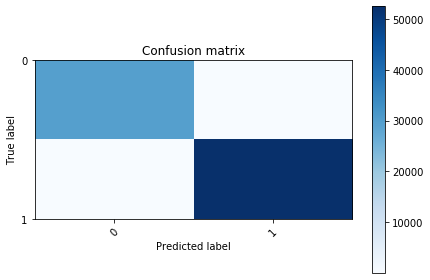

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29755
           1       1.00      1.00      1.00     52577

    accuracy                           1.00     82332
   macro avg       1.00      1.00      1.00     82332
weighted avg       1.00      1.00      1.00     82332



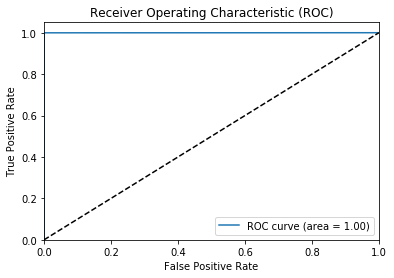

In [16]:
checkpointer = ModelCheckpoint(filepath=r"C:\Users\siris\OneDrive\Desktop\datasets\PROJECT1\best_weights.hdf5", verbose=0, save_best_only=True)
for i in range(5):
    print(i)
    model = Sequential()
    model.add(Dense(20, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
     # save best model

    # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
    model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 128, callbacks=[monitor,checkpointer],verbose=2,epochs=1000)
print('Training finished...Loading the best model')  
print()
model.load_weights(r"C:\Users\siris\OneDrive\Desktop\datasets\PROJECT1\best_weights.hdf5") # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)


pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)
print(pred)


y_true= np.argmax(y_test,axis=1) 

score = metrics.accuracy_score(y_true, pred)

print("Accuracy score: {}".format(score))


score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))

score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))


score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))


# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

lab = encode_text_index(df, 'label')
plt.figure()
plot_confusion_matrix(cm, lab)
plt.show()


print(classification_report(y_true, pred))


pred = model.predict(x_test)
pred = pred[:,1] # Only positive class (M)
plot_roc(pred,y_true)

# Main feature 2: K nearest neighbour

Accuracy score: 0.93345236360103
Precision score: 0.9402466845865659
Recall score: 0.93345236360103
F1 score: 0.9342723810575654
[[29153   602]
 [ 4877 47700]]
Plotting confusion matrix


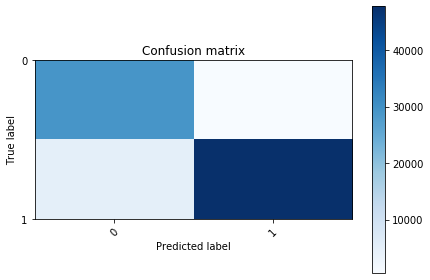

              precision    recall  f1-score   support

         0.0       0.86      0.98      0.91     29755
         1.0       0.99      0.91      0.95     52577

    accuracy                           0.93     82332
   macro avg       0.92      0.94      0.93     82332
weighted avg       0.94      0.93      0.93     82332



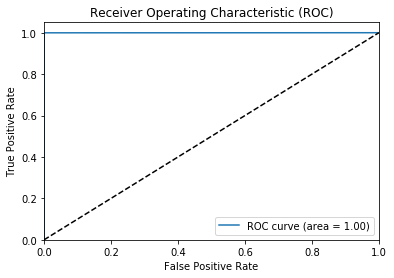

In [17]:
x,y = to_xy2(df,'label')

x_train, x_test, y_train, y_test = train_test_split(x , y , test_size=0.3195179336, random_state=42)

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=2)

knn.fit(x_train, y_train)

pred=knn.predict(x_test)

y_true= y_test

score = metrics.accuracy_score(y_true, pred)
print("Accuracy score: {}".format(score))


score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))

score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))


score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

lab = encode_text_index(df, 'label')
plt.figure()
plot_confusion_matrix(cm, lab)
plt.show()


print(classification_report(y_true, pred))


pred = model.predict(x_test)
pred = pred[:,1] # Only positive class (M)
plot_roc(pred,y_true)


# Main feature 3: Logistic Regression

Accuracy score: 0.99996356216295
Precision score: 0.999963562216754
Recall score: 0.99996356216295
F1 score: 0.9999635620300538
Plotting confusion matrix


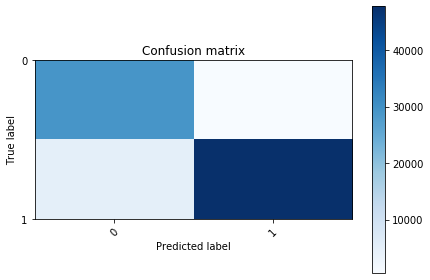

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     29755
         1.0       1.00      1.00      1.00     52577

    accuracy                           1.00     82332
   macro avg       1.00      1.00      1.00     82332
weighted avg       1.00      1.00      1.00     82332



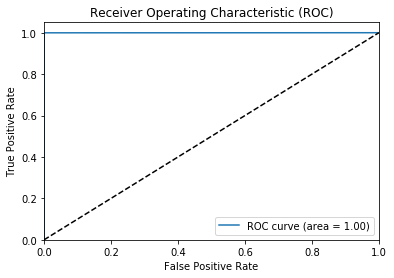

In [18]:
x,y = to_xy2(df,'label')

x_train, x_test, y_train, y_test = train_test_split(x , y , test_size=0.3195179336, random_state=42)
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model 
logreg = LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=1000 )


# fit the model with data
logreg.fit(x_train,y_train)

# predict the response for new observations
pred = logreg.predict(x_test)
y_true=y_test




score = metrics.accuracy_score(y_true, pred)

print("Accuracy score: {}".format(score))


score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))

score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))


score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))

print('Plotting confusion matrix')

lab = encode_text_index(df, 'label')
plt.figure()
plot_confusion_matrix(cm, lab)
plt.show()


print(classification_report(y_true, pred))


pred = model.predict(x_test)
pred = pred[:,1] # Only positive class (M)
plot_roc(pred,y_true)



# Main feature 4: Support Vector Machine

C:\Users\siris\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy score: 1.0
Precision score: 1.0
Recall score: 1.0
F1 score: 1.0
[[29755     0]
 [    0 52577]]
Plotting confusion matrix


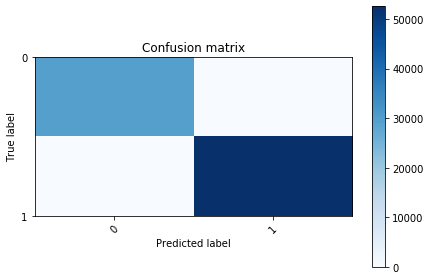

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     29755
         1.0       1.00      1.00      1.00     52577

    accuracy                           1.00     82332
   macro avg       1.00      1.00      1.00     82332
weighted avg       1.00      1.00      1.00     82332



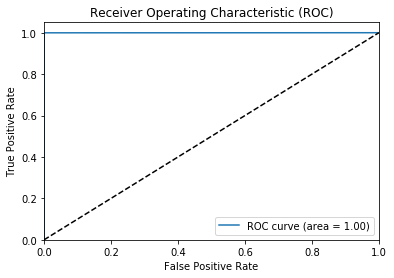

In [19]:
x,y = to_xy2(df,'label')

x_train, x_test, y_train, y_test = train_test_split(x , y , test_size=0.3195179336, random_state=42)

from sklearn import svm
from sklearn.svm import SVC

from sklearn.svm import LinearSVC
clf = LinearSVC(random_state=0, tol=1e-5,max_iter=2500)
clf.fit(x_train, y_train.ravel()) 
pred=clf.predict(x_test)
y_true = y_test

score = metrics.accuracy_score(y_true, pred)

print("Accuracy score: {}".format(score))


score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))

score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))


score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))

# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

lab = encode_text_index(df, 'label')
plt.figure()
plot_confusion_matrix(cm, lab)
plt.show()


print(classification_report(y_true, pred))


pred = model.predict(x_test)
pred = pred[:,1] # Only positive class (M)
plot_roc(pred,y_true)


# For fully connected neural network we found the best combination of paramaters to be:
## • **1. ACTIVATION :**: relu(best)
##                    : tanh didnt turn out to be a good option since tanh activation layers caused the F-1 score to drop from 99.99% to 50.4%
##                    : sigmoid didnt turn out be a good option since sigmoid activation layers caused the F-1 score to drop from 99.99% to 50.1%


## • **2. LAYERS AND NEURON COUNT** : Had minimal effect on F-1 score. But however increasing number of layers and nodes resulted in very small increase(negligible) in F-1 score for this dataset.
##                                  : Even with minimal layers and minimal number of nodes this dataset gave us almost a perfect F-1 score.So increasing number of layer/nodes didnt have a noticable
##                                    impact on the F-1 score. We went with the input layer 20 neurons and intermediate layer having 10 neurons.       


## • **3. OPTIMIZER:**: adam (best)
##                   : sgd is not a good option. F1 score obtained by sgd keeping other parameters same, caused the F-1 score to drop from 99.99% to 49.8%.


## The following Trials will show and compare efficiency of the other parameters to confirm the above stated best combination.

# Trial 1: Trying sgd optimizer for fully connected neural network

0
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 175341 samples, validate on 82332 samples
Epoch 1/1000
175341/175341 - 5s - loss: 20366445.9176 - val_loss: 0.6541
Epoch 2/1000
175341/175341 - 3s - loss: 0.6538 - val_loss: 0.6541
Epoch 3/1000
175341/175341 - 3s - loss: 0.6538 - val_loss: 0.6541
Epoch 4/1000
175341/175341 - 3s - loss: 0.6538 - val_loss: 0.6541
Epoch 5/1000
175341/175341 - 3s - loss: 0.6538 - val_loss: 0.6541
Epoch 6/1000
175341/175341 - 3s - loss: 0.6538 - val_loss: 0.6541
Epoch 00006: early stopping
1
Train on 175341 samples, validate on 82332 samples
Epoch 1/1000
175341/175341 - 3s - loss: 3922863.0477 - val_loss: 0.6544
Epoch 2/1000
175341/175341 - 3s - loss: 0.6540 - val_loss: 0.6543
Epoch 3/1000
175341/175341 - 3s - loss: 0.6539 - val_loss: 0.6543
Epoch 4/1000
175341/175341 - 3s - loss: 0.6539 - val_loss: 0.6543
Epoch 5/1000
175341/175341 - 3s - loss: 0.6539 - val_loss: 0.6543
Epoch 6/1000
175341/175341 - 3s - loss: 0.6539

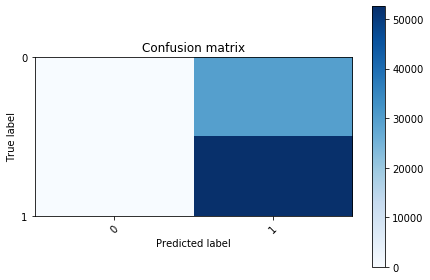

              precision    recall  f1-score   support

           0       1.00      0.00      0.00     29755
           1       0.64      1.00      0.78     52577

    accuracy                           0.64     82332
   macro avg       0.82      0.50      0.39     82332
weighted avg       0.77      0.64      0.50     82332



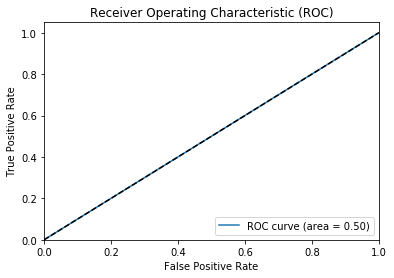

In [2]:
x,y = to_xy(df,'label')

x_train, x_test, y_train, y_test = train_test_split(x , y , test_size=0.3195179336, random_state=42)
checkpointer = ModelCheckpoint(filepath=r"C:\Users\siris\OneDrive\Desktop\datasets\PROJECT1\best_weights.hdf5", verbose=0, save_best_only=True)
for i in range(5):
    print(i)
    model = Sequential()
    model.add(Dense(20, input_dim=x.shape[1], activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='sgd')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
     # save best model

    # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
    model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 128, callbacks=[monitor,checkpointer],verbose=2,epochs=1000)
print('Training finished...Loading the best model')  
print()
model.load_weights(r"C:\Users\siris\OneDrive\Desktop\datasets\PROJECT1\best_weights.hdf5") # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)


pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)
print(pred)


y_true= np.argmax(y_test,axis=1) 

score = metrics.accuracy_score(y_true, pred)

print("Accuracy score: {}".format(score))


score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))

score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))


score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))


# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

lab = encode_text_index(df, 'label')
plt.figure()
plot_confusion_matrix(cm, lab)
plt.show()


print(classification_report(y_true, pred))


pred = model.predict(x_test)
pred = pred[:,1] # Only positive class (M)
plot_roc(pred,y_true)

# Trial 2: Trying with sigmoid activation layer
## Here we keep adam as optimizer since sgd was found to be an ineffective option. Layer and neural counts are kept same since they dont have a noticable impact on F-1 score for this dataset.

0
Train on 175341 samples, validate on 82332 samples
Epoch 1/1000
175341/175341 - 4s - loss: 0.6556 - val_loss: 0.6542
Epoch 2/1000
175341/175341 - 3s - loss: 0.6539 - val_loss: 0.6540
Epoch 3/1000
175341/175341 - 3s - loss: 0.6535 - val_loss: 0.6543
Epoch 4/1000
175341/175341 - 3s - loss: 0.6541 - val_loss: 0.6542
Epoch 5/1000
175341/175341 - 3s - loss: 0.6539 - val_loss: 0.6542
Epoch 6/1000
175341/175341 - 3s - loss: 0.6539 - val_loss: 0.6543
Epoch 00006: early stopping
1
Train on 175341 samples, validate on 82332 samples
Epoch 1/1000
175341/175341 - 3s - loss: 0.6553 - val_loss: 0.6543
Epoch 2/1000
175341/175341 - 3s - loss: 0.6540 - val_loss: 0.6542
Epoch 3/1000
175341/175341 - 3s - loss: 0.6540 - val_loss: 0.6542
Epoch 4/1000
175341/175341 - 3s - loss: 0.6540 - val_loss: 0.6546
Epoch 5/1000
175341/175341 - 3s - loss: 0.6540 - val_loss: 0.6542
Epoch 6/1000
175341/175341 - 3s - loss: 0.6539 - val_loss: 0.6543
Epoch 00006: early stopping
2
Train on 175341 samples, validate on 82332 s

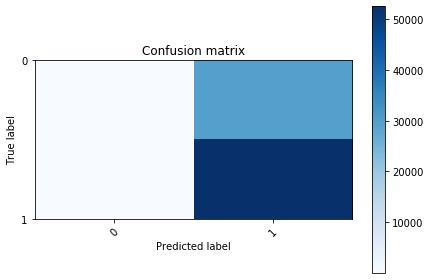

              precision    recall  f1-score   support

           0       0.98      0.01      0.01     29755
           1       0.64      1.00      0.78     52577

    accuracy                           0.64     82332
   macro avg       0.81      0.50      0.40     82332
weighted avg       0.76      0.64      0.50     82332



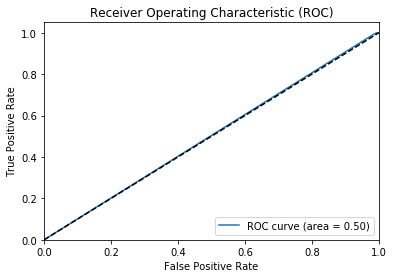

In [3]:
checkpointer = ModelCheckpoint(filepath=r"C:\Users\siris\OneDrive\Desktop\datasets\PROJECT1\best_weights.hdf5", verbose=0, save_best_only=True)
for i in range(5):
    print(i)
    model = Sequential()
    model.add(Dense(20, input_dim=x.shape[1], activation='sigmoid'))
    model.add(Dense(10, activation='sigmoid'))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
     # save best model

    # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
    model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 128, callbacks=[monitor,checkpointer],verbose=2,epochs=1000)
print('Training finished...Loading the best model')  
print()
model.load_weights(r"C:\Users\siris\OneDrive\Desktop\datasets\PROJECT1\best_weights.hdf5") # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)


pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)
print(pred)


y_true= np.argmax(y_test,axis=1) 

score = metrics.accuracy_score(y_true, pred)

print("Accuracy score: {}".format(score))


score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))

score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))


score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))


# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

lab = encode_text_index(df, 'label')
plt.figure()
plot_confusion_matrix(cm, lab)
plt.show()


print(classification_report(y_true, pred))


pred = model.predict(x_test)
pred = pred[:,1] # Only positive class (M)
plot_roc(pred,y_true)


# Trial 3: Trying tanh activation layer
## Here we keep adam as optimizer since sgd was found to be an ineffective option. Layer and neural counts are kept same since they dont have a noticable impact on F-1 score for this dataset.

0
Train on 175341 samples, validate on 82332 samples
Epoch 1/1000
175341/175341 - 7s - loss: 0.6600 - val_loss: 0.6532
Epoch 2/1000
175341/175341 - 4s - loss: 0.6561 - val_loss: 0.6529
Epoch 3/1000
175341/175341 - 5s - loss: 0.6576 - val_loss: 0.6536
Epoch 4/1000
175341/175341 - 5s - loss: 0.6539 - val_loss: 0.6535
Epoch 5/1000
175341/175341 - 5s - loss: 0.6539 - val_loss: 0.6536
Epoch 6/1000
175341/175341 - 4s - loss: 0.6536 - val_loss: 0.6534
Epoch 00006: early stopping
1
Train on 175341 samples, validate on 82332 samples
Epoch 1/1000
175341/175341 - 6s - loss: 0.6572 - val_loss: 0.6536
Epoch 2/1000
175341/175341 - 4s - loss: 0.6542 - val_loss: 0.6532
Epoch 3/1000
175341/175341 - 5s - loss: 0.6531 - val_loss: 0.6528
Epoch 4/1000
175341/175341 - 5s - loss: 0.6528 - val_loss: 0.6523
Epoch 5/1000
175341/175341 - 5s - loss: 0.6545 - val_loss: 0.6550
Epoch 6/1000
175341/175341 - 4s - loss: 0.6535 - val_loss: 0.6535
Epoch 7/1000
175341/175341 - 4s - loss: 0.6544 - val_loss: 0.6542
Epoch 8/

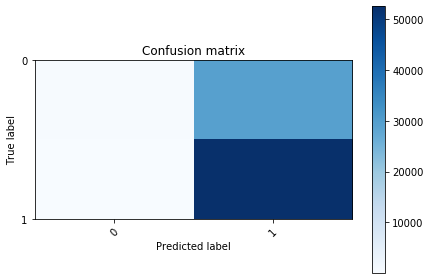

              precision    recall  f1-score   support

           0       0.89      0.01      0.02     29755
           1       0.64      1.00      0.78     52577

    accuracy                           0.64     82332
   macro avg       0.77      0.50      0.40     82332
weighted avg       0.73      0.64      0.50     82332



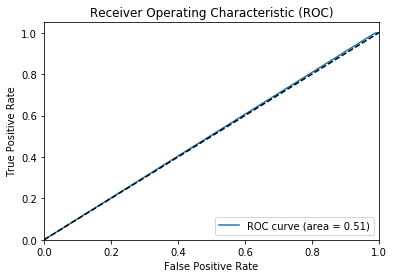

In [22]:

checkpointer = ModelCheckpoint(filepath=r"C:\Users\siris\OneDrive\Desktop\datasets\PROJECT1\best_weights.hdf5", verbose=0, save_best_only=True)
for i in range(5):
    print(i)
    model = Sequential()
    model.add(Dense(20, input_dim=x.shape[1], activation='tanh'))
    model.add(Dense(10, activation='tanh'))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
     # save best model

    # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.
    model.fit(x_train,y_train,validation_data=(x_test,y_test), batch_size= 128, callbacks=[monitor,checkpointer],verbose=2,epochs=1000)
print('Training finished...Loading the best model')  
print()
model.load_weights(r"C:\Users\siris\OneDrive\Desktop\datasets\PROJECT1\best_weights.hdf5") # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)


pred = np.argmax(pred,axis=1) # raw probabilities to choose class (highest probability)
print(pred)


y_true= np.argmax(y_test,axis=1) 

score = metrics.accuracy_score(y_true, pred)

print("Accuracy score: {}".format(score))


score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(score))

score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(score))


score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(score))


# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
print(cm)


print('Plotting confusion matrix')

lab = encode_text_index(df, 'label')
plt.figure()
plot_confusion_matrix(cm, lab)
plt.show()


print(classification_report(y_true, pred))


pred = model.predict(x_test)
pred = pred[:,1] # Only positive class (M)
plot_roc(pred,y_true)


# Conclusion:
## best parameters:
## • Activation: relu
## • Optimizer: adam 